<a href="https://colab.research.google.com/github/sandeepmbm/starnet/blob/master/SSRNET_model_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import logging
import sys
import numpy as np
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout, Multiply, Embedding, Lambda, Add, Concatenate, Activation
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.utils import plot_model
from keras.engine.topology import Layer
from keras import activations, initializers, regularizers, constraints


sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)

class SSR_net:
    def __init__(self, image_size,stage_num,lambda_local,lambda_d):
        #K.common.image_dim_ordering()
        if K.image_data_format() == "th":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

        self.stage_num = stage_num
        self.lambda_local = lambda_local
        self.lambda_d = lambda_d

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")
        inputs = Input(shape=self._input_shape)
        print('inputs:',inputs.shape)
        #X_im = uint8(inputs(:,:,:,1))
        #X_im=X_im.resahpe(:,:,1)
        #-------------------------------------------------------------------------------------------------------------------------
        x = Conv2D(32,(3,3))(inputs)
        print('1Conv:',x.shape)
        x = BatchNormalization(axis=self._channel_axis)(x)
        print('1BN:',x.shape)
        x = Activation('relu')(x)
        x_layer1 = AveragePooling2D(2,2)(x)
        print('1AP:',x_layer1.shape)
        
        x = Conv2D(32,(3,3))(x_layer1)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        x_layer2 = AveragePooling2D(2,2)(x)
        print('2AP:',x_layer2.shape)
        x = Conv2D(32,(3,3))(x_layer2)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        x_layer3 = AveragePooling2D(2,2)(x)
        print('3AP:',x_layer3.shape)
        x = Conv2D(32,(3,3))(x_layer3)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        print('4A:',x.shape, 'x:',x)
        #-------------------------------------------------------------------------------------------------------------------------
        s = Conv2D(16,(3,3))(inputs)
        print('2SConv:',s.shape)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer1 = MaxPooling2D(2,2)(s)
        print('2SMP1:',s_layer1.shape)
        s = Conv2D(16,(3,3))(s_layer1)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer2 = MaxPooling2D(2,2)(s)
        print('2SMP2:',s_layer2.shape)
        s = Conv2D(16,(3,3))(s_layer2)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer3 = MaxPooling2D(2,2)(s)
        print('2SMP3:',s_layer3.shape)
        s = Conv2D(16,(3,3))(s_layer3)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        print('2SMP4:',s.shape, 's:',s)     
        #-------------------------------------------------------------------------------------------------------------------------
        # Classifier block
        s_layer4 = Conv2D(10,(1,1),activation='relu')(s)
        print('s_layer4:',s_layer4.shape, s_layer4)
        s_layer4 = Flatten()(s_layer4)
        s_layer4_mix = Dropout(0.2)(s_layer4)
        s_layer4_mix = Dense(units=self.stage_num[0], activation="relu")(s_layer4_mix)
        
        x_layer4 = Conv2D(10,(1,1),activation='relu')(x)
        print('x_layer4:',x_layer4.shape, x_layer4)
        x_layer4 = Flatten()(x_layer4)
        x_layer4_mix = Dropout(0.2)(x_layer4)
        x_layer4_mix = Dense(units=self.stage_num[0], activation="relu")(x_layer4_mix)
        
        print('X:',x_layer4.shape,'S:',s_layer4.shape) 
        #print('sS:',s.shape,) 
        feat_a_s1_pre = Multiply()([s_layer4,x_layer4])
        delta_s1 = Dense(1,activation='tanh',name='delta_s1')(feat_a_s1_pre)
        print('delta_s1:',delta_s1.shape, delta_s1)
        feat_a_s1 = Multiply()([s_layer4_mix,x_layer4_mix])
        feat_a_s1 = Dense(2*self.stage_num[0],activation='relu')(feat_a_s1)
        pred_a_s1 = Dense(units=self.stage_num[0], activation="relu",name='pred_age_stage1')(feat_a_s1)
        #feat_local_s1 = Lambda(lambda x: x/10)(feat_a_s1)
        #feat_a_s1_local = Dropout(0.2)(pred_a_s1)
        local_s1 = Dense(units=self.stage_num[0], activation='tanh', name='local_delta_stage1')(feat_a_s1)
        #-------------------------------------------------------------------------------------------------------------------------
        s_layer2 = Conv2D(10,(1,1),activation='relu')(s_layer2)
        s_layer2 = MaxPooling2D(4,4)(s_layer2)
        s_layer2 = Flatten()(s_layer2)
        s_layer2_mix = Dropout(0.2)(s_layer2)
        s_layer2_mix = Dense(self.stage_num[1],activation='relu')(s_layer2_mix)
        
        x_layer2 = Conv2D(10,(1,1),activation='relu')(x_layer2)
        x_layer2 = AveragePooling2D(4,4)(x_layer2)
        x_layer2 = Flatten()(x_layer2)
        x_layer2_mix = Dropout(0.2)(x_layer2)
        x_layer2_mix = Dense(self.stage_num[1],activation='relu')(x_layer2_mix)
        
        feat_a_s2_pre = Multiply()([s_layer2,x_layer2])
        delta_s2 = Dense(1,activation='tanh',name='delta_s2')(feat_a_s2_pre)
        
        feat_a_s2 = Multiply()([s_layer2_mix,x_layer2_mix])
        feat_a_s2 = Dense(2*self.stage_num[1],activation='relu')(feat_a_s2)
        pred_a_s2 = Dense(units=self.stage_num[1], activation="relu",name='pred_age_stage2')(feat_a_s2)
        #feat_local_s2 = Lambda(lambda x: x/10)(feat_a_s2)
        #feat_a_s2_local = Dropout(0.2)(pred_a_s2)
        local_s2 = Dense(units=self.stage_num[1], activation='tanh', name='local_delta_stage2')(feat_a_s2)
        #-------------------------------------------------------------------------------------------------------------------------
        s_layer1 = Conv2D(10,(1,1),activation='relu')(s_layer1)
        s_layer1 = MaxPooling2D(8,8)(s_layer1)
        s_layer1 = Flatten()(s_layer1)
        s_layer1_mix = Dropout(0.2)(s_layer1)
        s_layer1_mix = Dense(self.stage_num[2],activation='relu')(s_layer1_mix)
        
        x_layer1 = Conv2D(10,(1,1),activation='relu')(x_layer1)
        x_layer1 = AveragePooling2D(8,8)(x_layer1)
        x_layer1 = Flatten()(x_layer1)
        x_layer1_mix = Dropout(0.2)(x_layer1)
        x_layer1_mix = Dense(self.stage_num[2],activation='relu')(x_layer1_mix)

        feat_a_s3_pre = Multiply()([s_layer1,x_layer1])
        delta_s3 = Dense(1,activation='tanh',name='delta_s3')(feat_a_s3_pre)
        
        feat_a_s3 = Multiply()([s_layer1_mix,x_layer1_mix])
        feat_a_s3 = Dense(2*self.stage_num[2],activation='relu')(feat_a_s3)
        pred_a_s3 = Dense(units=self.stage_num[2], activation="relu",name='pred_age_stage3')(feat_a_s3)
        #feat_local_s3 = Lambda(lambda x: x/10)(feat_a_s3)
        #feat_a_s3_local = Dropout(0.2)(pred_a_s3)
        local_s3 = Dense(units=self.stage_num[2], activation='tanh', name='local_delta_stage3')(feat_a_s3)
        #-------------------------------------------------------------------------------------------------------------------------
        def merge_age(x,s1,s2,s3,lambda_local,lambda_d):
            a = x[0][:,0]*0
            b = x[0][:,0]*0
            c = x[0][:,0]*0
            A = s1*s2*s3
            V = 101

            for i in range(0,s1):
                a = a+(i+lambda_local*x[6][:,i])*x[0][:,i]
            a = K.expand_dims(a,-1)
            a = a/(s1*(1+lambda_d*x[3]))

            for j in range(0,s2):
                b = b+(j+lambda_local*x[7][:,j])*x[1][:,j]
            b = K.expand_dims(b,-1)
            b = b/(s1*(1+lambda_d*x[3]))/(s2*(1+lambda_d*x[4]))

            for k in range(0,s3):
                c = c+(k+lambda_local*x[8][:,k])*x[2][:,k]
            c = K.expand_dims(c,-1)
            c = c/(s1*(1+lambda_d*x[3]))/(s2*(1+lambda_d*x[4]))/(s3*(1+lambda_d*x[5]))


            age = (a+b+c)*V
            return age
        
        pred_a = Lambda(merge_age,arguments={'s1':self.stage_num[0],'s2':self.stage_num[1],'s3':self.stage_num[2],'lambda_local':self.lambda_local,'lambda_d':self.lambda_d},output_shape=(1,),name='pred_a')([pred_a_s1,pred_a_s2,pred_a_s3,delta_s1,delta_s2,delta_s3, local_s1, local_s2, local_s3])

        model = Model(inputs=inputs, outputs=pred_a)

        return model

class SSR_net_general:
    def __init__(self, image_size,stage_num,lambda_local,lambda_d):
        
        if K.image_data_format() == "th":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

        self.stage_num = stage_num
        self.lambda_local = lambda_local
        self.lambda_d = lambda_d

#   def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")
        inputs = Input(shape=self._input_shape)
        print('input:',inputs.shape)
        #-------------------------------------------------------------------------------------------------------------------------
        x = Conv2D(32,(3,3))(inputs)
        print('1stCONV2D',x.shape)
        x = BatchNormalization(axis=self._channel_axis)(x)
        print('1BN:',x.shape)
        x = Activation('relu')(x)
        x_layer1 = AveragePooling2D(2,2)(x)
        print('1AP:',x_layer1.shape)
        x = Conv2D(32,(3,3))(x_layer1)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        x_layer2 = AveragePooling2D(2,2)(x)
        print('2AP:',x_layer2.shape)
        x = Conv2D(32,(3,3))(x_layer2)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        x_layer3 = AveragePooling2D(2,2)(x)
        print('3AP:',x_layer3.shape)
        x = Conv2D(32,(3,3))(x_layer3)
        x = BatchNormalization(axis=self._channel_axis)(x)
        x = Activation('relu')(x)
        print('4:',x.shape)
        #-------------------------------------------------------------------------------------------------------------------------
        s = Conv2D(16,(3,3))(inputs)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer1 = MaxPooling2D(2,2)(s)
        s = Conv2D(16,(3,3))(s_layer1)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer2 = MaxPooling2D(2,2)(s)
        s = Conv2D(16,(3,3))(s_layer2)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        s_layer3 = MaxPooling2D(2,2)(s)
        s = Conv2D(16,(3,3))(s_layer3)
        s = BatchNormalization(axis=self._channel_axis)(s)
        s = Activation('tanh')(s)
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Classifier block
        s_layer4 = Conv2D(10,(1,1),activation='relu')(s)
        s_layer4 = Flatten()(s_layer4)
        s_layer4_mix = Dropout(0.2)(s_layer4)
        s_layer4_mix = Dense(units=self.stage_num[0], activation="relu")(s_layer4_mix)
        
        x_layer4 = Conv2D(10,(1,1),activation='relu')(x)
        x_layer4 = Flatten()(x_layer4)
        x_layer4_mix = Dropout(0.2)(x_layer4)
        x_layer4_mix = Dense(units=self.stage_num[0], activation="relu")(x_layer4_mix)
        
        feat_s1_pre = Multiply()([s_layer4,x_layer4])
        delta_s1 = Dense(1,activation='tanh',name='delta_s1')(feat_s1_pre)
        
        feat_s1 = Multiply()([s_layer4_mix,x_layer4_mix])
        feat_s1 = Dense(2*self.stage_num[0],activation='relu')(feat_s1)
        pred_s1 = Dense(units=self.stage_num[0], activation="relu",name='pred_stage1')(feat_s1)
        local_s1 = Dense(units=self.stage_num[0], activation='tanh', name='local_delta_stage1')(feat_s1)
        #-------------------------------------------------------------------------------------------------------------------------
        s_layer2 = Conv2D(10,(1,1),activation='relu')(s_layer2)
        s_layer2 = MaxPooling2D(4,4)(s_layer2)
        s_layer2 = Flatten()(s_layer2)
        s_layer2_mix = Dropout(0.2)(s_layer2)
        s_layer2_mix = Dense(self.stage_num[1],activation='relu')(s_layer2_mix)
        
        x_layer2 = Conv2D(10,(1,1),activation='relu')(x_layer2)
        x_layer2 = AveragePooling2D(4,4)(x_layer2)
        x_layer2 = Flatten()(x_layer2)
        x_layer2_mix = Dropout(0.2)(x_layer2)
        x_layer2_mix = Dense(self.stage_num[1],activation='relu')(x_layer2_mix)
        
        feat_s2_pre = Multiply()([s_layer2,x_layer2])
        delta_s2 = Dense(1,activation='tanh',name='delta_s2')(feat_s2_pre)
        
        feat_s2 = Multiply()([s_layer2_mix,x_layer2_mix])
        feat_s2 = Dense(2*self.stage_num[1],activation='relu')(feat_s2)
        pred_s2 = Dense(units=self.stage_num[1], activation="relu",name='pred_stage2')(feat_s2)
        local_s2 = Dense(units=self.stage_num[1], activation='tanh', name='local_delta_stage2')(feat_s2)
        #-------------------------------------------------------------------------------------------------------------------------
        s_layer1 = Conv2D(10,(1,1),activation='relu')(s_layer1)
        s_layer1 = MaxPooling2D(8,8)(s_layer1)
        s_layer1 = Flatten()(s_layer1)
        s_layer1_mix = Dropout(0.2)(s_layer1)
        s_layer1_mix = Dense(self.stage_num[2],activation='relu')(s_layer1_mix)
        
        x_layer1 = Conv2D(10,(1,1),activation='relu')(x_layer1)
        x_layer1 = AveragePooling2D(8,8)(x_layer1)
        x_layer1 = Flatten()(x_layer1)
        x_layer1_mix = Dropout(0.2)(x_layer1)
        x_layer1_mix = Dense(self.stage_num[2],activation='relu')(x_layer1_mix)

        feat_s3_pre = Multiply()([s_layer1,x_layer1])
        delta_s3 = Dense(1,activation='tanh',name='delta_s3')(feat_s3_pre)
        
        feat_s3 = Multiply()([s_layer1_mix,x_layer1_mix])
        feat_s3 = Dense(2*self.stage_num[2],activation='relu')(feat_s3)
        pred_s3 = Dense(units=self.stage_num[2], activation="relu",name='pred_stage3')(feat_s3)
        local_s3 = Dense(units=self.stage_num[2], activation='tanh', name='local_delta_stage3')(feat_s3)
        #-------------------------------------------------------------------------------------------------------------------------
        
        def SSR_module(x,s1,s2,s3,lambda_local,lambda_d):
            a = x[0][:,0]*0
            b = x[0][:,0]*0
            c = x[0][:,0]*0
            V = 1

            for i in range(0,s1):
                a = a+(i+lambda_local*x[6][:,i])*x[0][:,i]
            a = K.expand_dims(a,-1)
            a = a/(s1*(1+lambda_d*x[3]))

            for j in range(0,s2):
                b = b+(j+lambda_local*x[7][:,j])*x[1][:,j]
            b = K.expand_dims(b,-1)
            b = b/(s1*(1+lambda_d*x[3]))/(s2*(1+lambda_d*x[4]))

            for k in range(0,s3):
                c = c+(k+lambda_local*x[8][:,k])*x[2][:,k]
            c = K.expand_dims(c,-1)
            c = c/(s1*(1+lambda_d*x[3]))/(s2*(1+lambda_d*x[4]))/(s3*(1+lambda_d*x[5]))


            out = (a+b+c)*V
            return out
        
        pred = Lambda(SSR_module,arguments={'s1':self.stage_num[0],'s2':self.stage_num[1],'s3':self.stage_num[2],'lambda_local':self.lambda_local,'lambda_d':self.lambda_d},name='pred')([pred_s1,pred_s2,pred_s3,delta_s1,delta_s2,delta_s3, local_s1, local_s2, local_s3])

        model = Model(inputs=inputs, outputs=pred)

        return model


img_size = 64
stage_num = [3,3,3]
lambda_local = 1
lambda_d = 1
#model=SSR_net_general(img_size,stage_num, lambda_local, lambda_d)()
model = SSR_net(img_size,stage_num, lambda_local, lambda_d)()
model.compile(optimizer=Adam(), loss=["mae"], metrics={'pred_a':'mae'})

#from contextlib import redirect_stdout

#with open('modelsummary.txt', 'w') as f:
#    with redirect_stdout(f):
#        model.summary()
model.summary()


inputs: (None, 64, 64, 3)
1Conv: (None, 62, 62, 32)
1BN: (None, 62, 62, 32)
1AP: (None, 31, 31, 32)
2AP: (None, 14, 14, 32)
3AP: (None, 6, 6, 32)
4A: (None, 4, 4, 32) x: KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 32), dtype=tf.float32, name=None), name='activation_27/Relu:0', description="created by layer 'activation_27'")
2SConv: (None, 62, 62, 16)
2SMP1: (None, 31, 31, 16)
2SMP2: (None, 14, 14, 16)
2SMP3: (None, 6, 6, 16)
2SMP4: (None, 4, 4, 16) s: KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 16), dtype=tf.float32, name=None), name='activation_31/Tanh:0', description="created by layer 'activation_31'")
s_layer4: (None, 4, 4, 10) KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 10), dtype=tf.float32, name=None), name='conv2d_50/Relu:0', description="created by layer 'conv2d_50'")
x_layer4: (None, 4, 4, 10) KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 10), dtype=tf.float32, name=None), name='conv2d_51/Relu:0', description="created by layer 'conv2d_51'")
X: (No

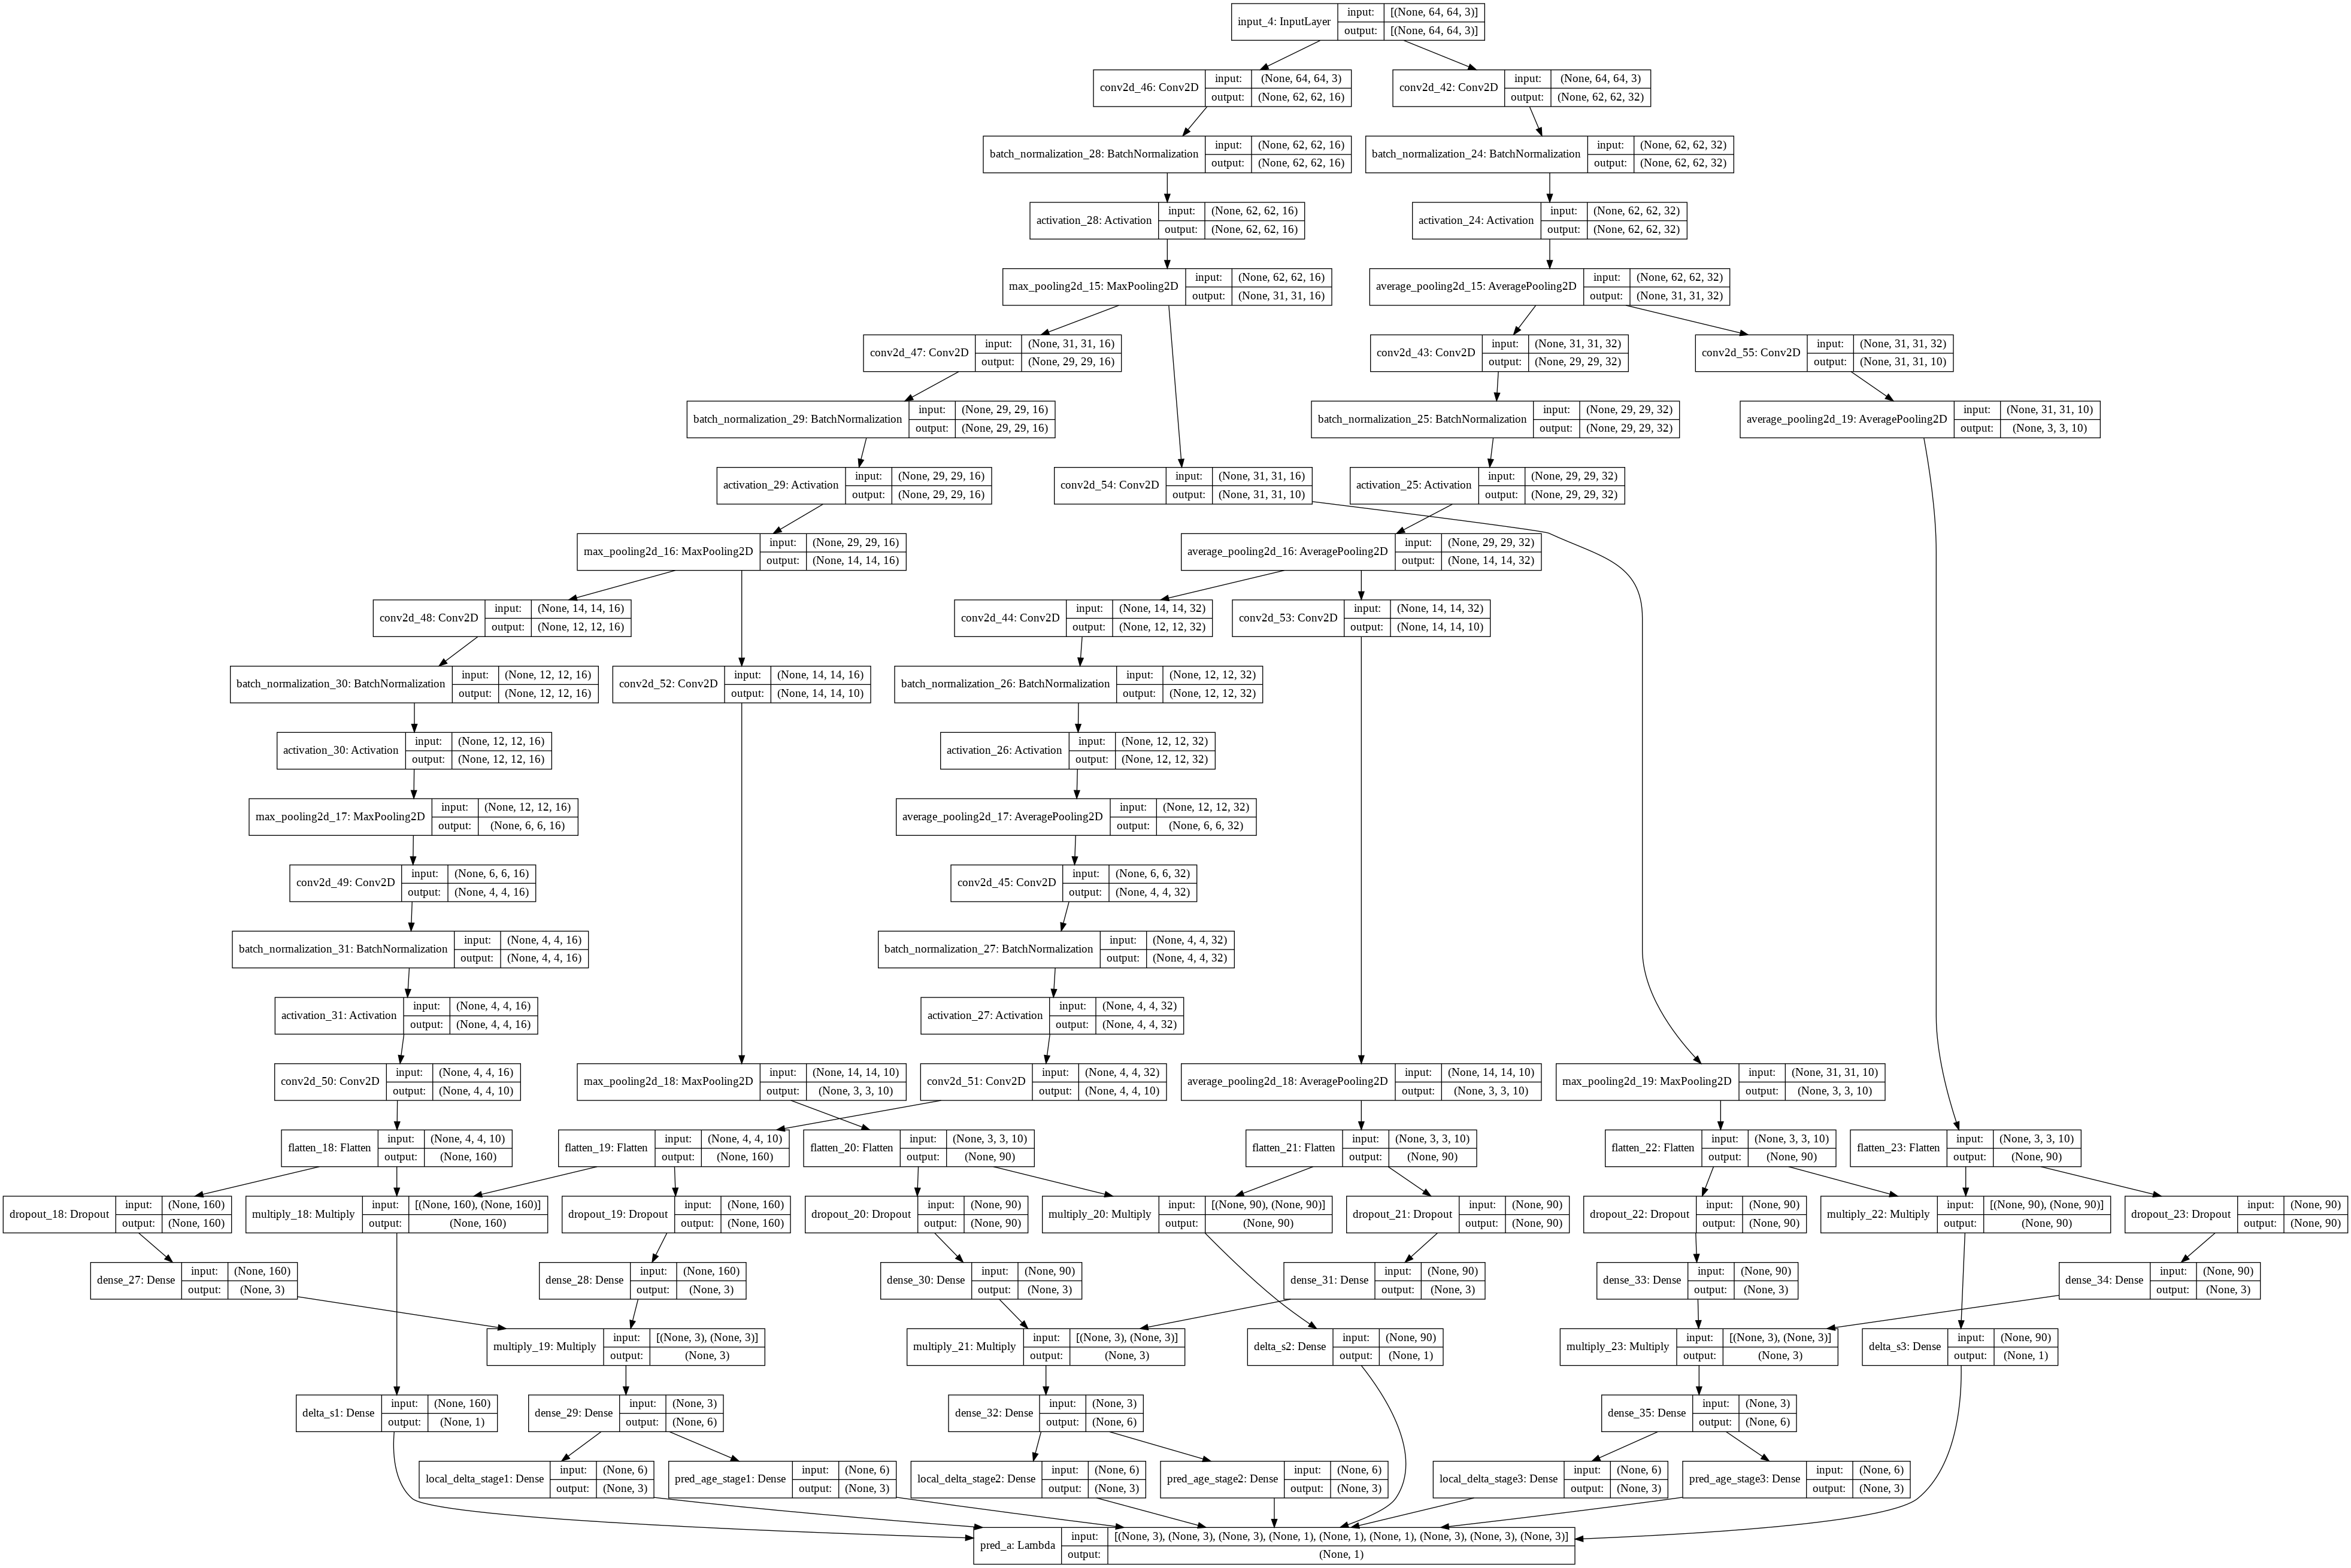

In [82]:
plot_model(model, show_shapes=True, to_file='SSR.png')

In [ ]:
!ls
#from google.colab import files
#files.upload()
#files.download('chess.jpg')

chess.jpg  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
!ls
#import cv2
#import matplotlib.pyplot as plt
#img=cv2.imread('chess.jpg')
#img=cv2.resize(img,(64,64))
#plt.imshow(img)
#print(img.shape)
#IMG_SIZE = 64
#X = np.array(img).reshape(IMG_SIZE, IMG_SIZE,3)
#y=[1]
#y = np.array(y)
#print(type(X),type(y))
#print(X.shape,y.shape)
#plt.imshow(X)
from keras.preprocessing import image
img1=image.load_img('chess.jpg', target_size = (64, 64))
img1 = image.img_to_array(img1)
img = np.expand_dims(img1, axis = 0)
print(img.shape)
#plt.imshow(img)
y=[1]
y=np.array(y)
#history = model.fit(img,y,epochs=1, batch_size=1, validation_data=(img,y))

chess.jpg	      multiple_vgg_blocks.png	  sample_data
inception_module.png  naive_inception_module.png  SSR.png
(1, 64, 64, 3)


[<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_4')>, <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'conv2d_46')>, <KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'conv2d_42')>, <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'batch_normalization_28')>, <KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'batch_normalization_24')>, <KerasTensor: shape=(None, 62, 62, 16) dtype=float32 (created by layer 'activation_28')>, <KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'activation_24')>, <KerasTensor: shape=(None, 31, 31, 16) dtype=float32 (created by layer 'max_pooling2d_15')>, <KerasTensor: shape=(None, 31, 31, 32) dtype=float32 (created by layer 'average_pooling2d_15')>, <KerasTensor: shape=(None, 29, 29, 16) dtype=float32 (created by layer 'conv2d_47')>, <KerasTensor: shape=(None, 29, 29, 32) dtype=float32 (created by layer 'conv2d_43')>, <Ker

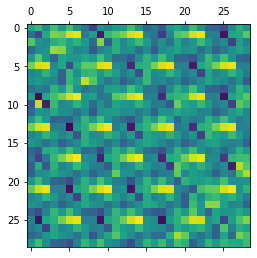

In [69]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
print(layer_outputs)
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(img)
first_layer_activation = activations[11]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

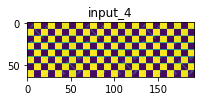

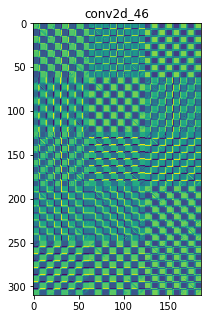

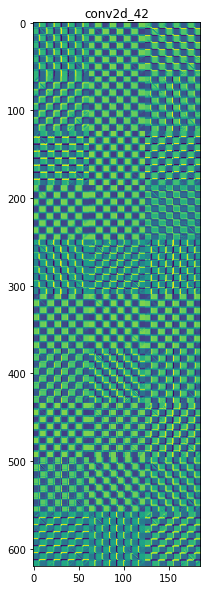

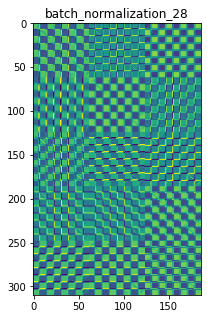

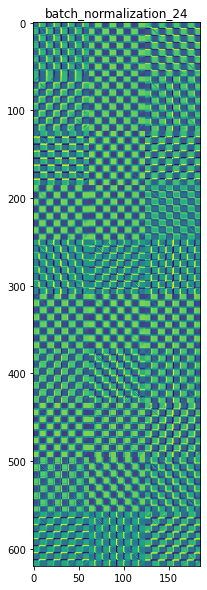

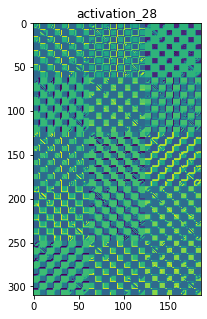

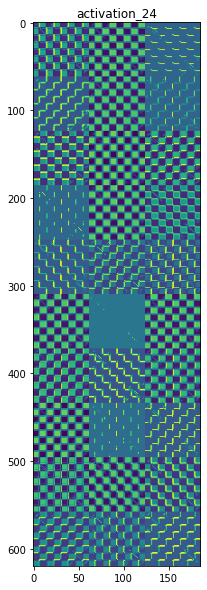

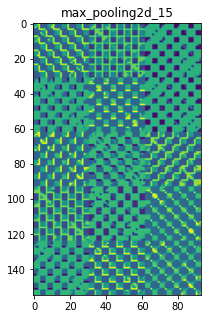

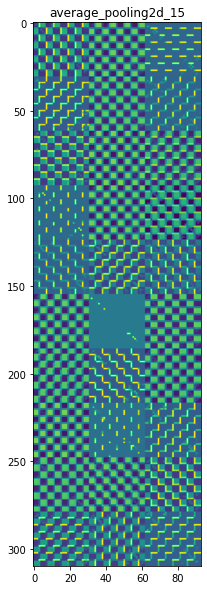

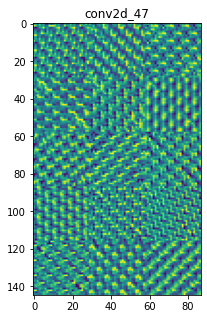

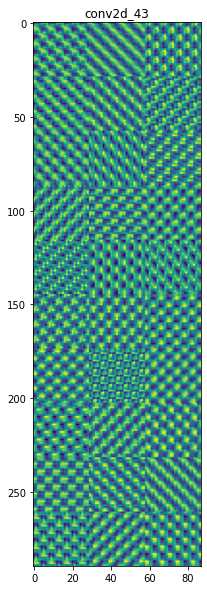

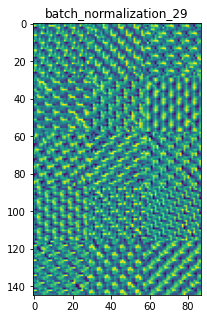

In [80]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
#print(len(layer_names))
images_per_row=3
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
# function for creating a naive inception block
def inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving chess.jpg to chess.jpg


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 256, 256, 64) 256         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 256, 256, 128 3584        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 32) 2432        input_11[0][0]                   
___________________________________________________________________________________________

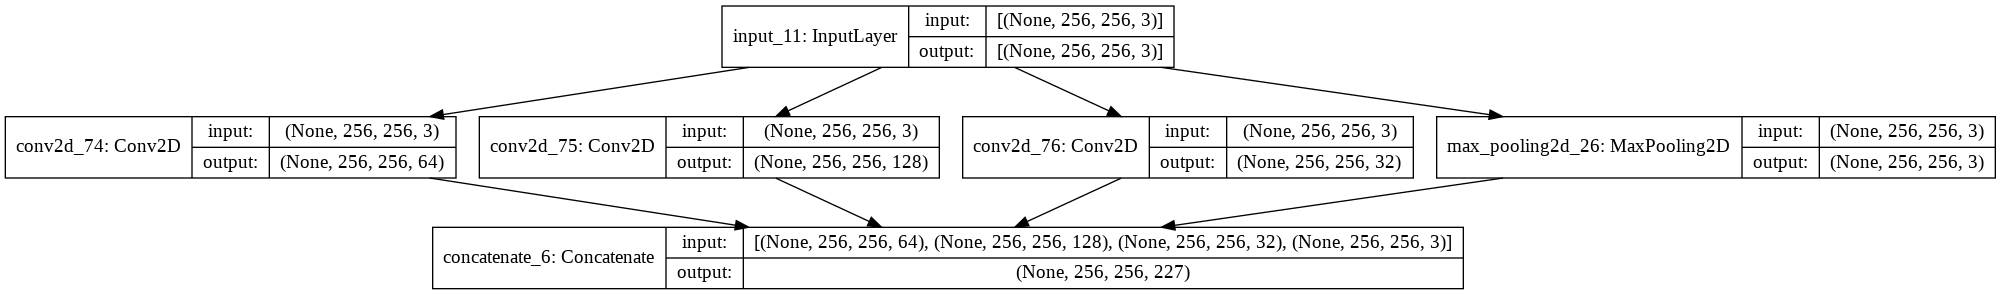

In [93]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
 
# function for creating a naive inception block
def naive_inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [101]:
model.compile(optimizer=Adam(), loss=["mae"], metrics={'pred_a':'mae'})
print(img1.shape)
#history = model.fit(img1,y,epochs=1, batch_size=1, validation_data=(img,y))

(64, 64, 3)


Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 256, 256, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 256, 256, 64) 256         input_13[0][0]                   
___________________________________________________________________________________________

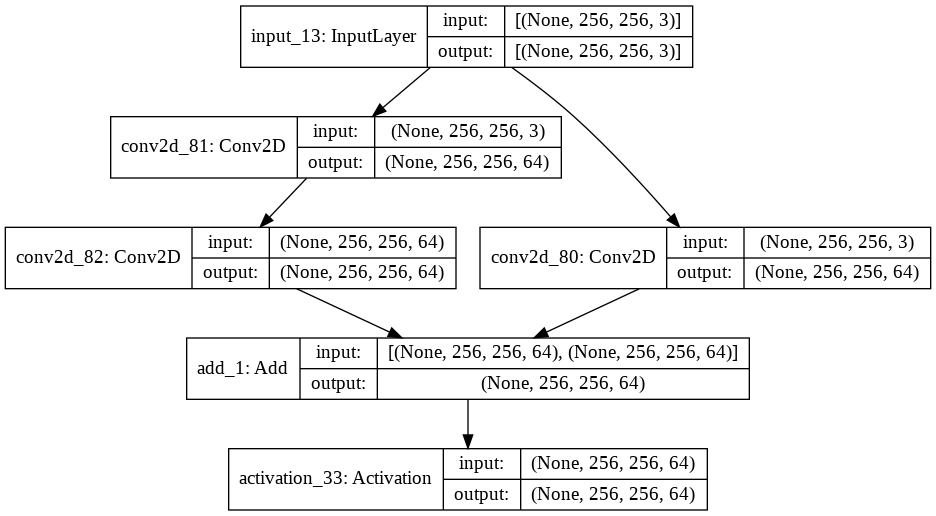

In [104]:

# example of a CNN model with an identity or projection residual module
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.utils import plot_model
 
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out
 
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [3]:
#!ls
#!pip install git+git://github.com/keplr-io/quiver.git


sample_data
  Cloning git://github.com/keplr-io/quiver.git to /tmp/pip-req-build-v_f9nshw
  Running command git clone -q git://github.com/keplr-io/quiver.git /tmp/pip-req-build-v_f9nshw
     |████████████████████████████████| 5.5MB 24.6MB/s 
     |████████████████████████████████| 163kB 58.5MB/s 
     |████████████████████████████████| 245kB 59.8MB/s 
  Created wheel for quiver-engine: filename=quiver_engine-0.1.4.1.5-cp36-none-any.whl size=442529 sha256=e0499d223dbb71953b45a8e4e7f14ddde7fed5423922ab929b787311b5239774
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfw_6yn/wheels/f8/3d/8c/01767f90bbdb04d278ca603ff5411b06a8778421a7bd01c720
Successfully built quiver-engine


In [6]:
import quiver_engine
from quiver_engine import server
server.launch(model)

ImportError: ignored

# New Section